<a href="https://colab.research.google.com/github/tuncayyaylali/my_projects/blob/main/Hava_Kalitesi_Tahmini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SMOOTHING ve İSTATİKSEL YÖNTEMLERLE HAVA KALİTESİ TAHMİNİ**

Çevre, Şehircilik ve İklim Değişikliği Bakanlığı' nca karar vericilerin ve yetkili otoritelerin hava kalitesinin iyileştirilmesi amacıyla oluşturacakları politika, strateji ve eylem planlarını en doğru, güvenilir ve temsiliyeti yüksek hava kalitesi verisi ile desteklemek amacıyla 2005 yılında kurulmuş olan Ulusal Hava Kalitesi
İzleme Ağı, ülke geneline yayılmış olan izleme istasyonları ile görev yapmaktadır. Halkın hava kalitesi verisine erişim hakkı kapsamında www.havaizleme.gov.tr internet adresinde kamuoyu ile paylaşılmakta olan hava kalitesi izleme verisi Türkiye genelinde tüm illerde hizmet vermketedir. Söz konusu istasyonlarda anlık ölçümlerle partiküler madde, azot oksit, kükürt dioksit, karbon monoksit ve ozon parametrelerine dair mevcut hava kalitesi ölçümleri izlenmektedir.

Çalışma kapsamında, seçilen bir istasyona ait 15 yıllık azor dioksit emisyonuna ait ölçüm sonuçları değerlendirilmiş ve 2022 yılı aylık tahminlerde bulunulmuştur. 

Single Exponential Smoothing, Double Exponential Smoothing, Triple Exponential Smoothing, ARIMA ve SARIMA yöntemleriyle değerlendirme yapılmış ve sonuçları karşılaştırılmıştır. En iyi başarıya sahip yöntem kullanılarak oluşturulan final modellemesiyle 2022 yılı için Ankara-Bahçelievler İstasyonu' nun azot dioksit (NO2) emisyonları tahmin edilmiştir.

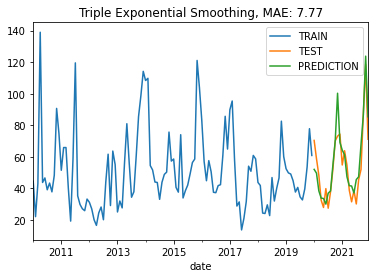

**KÜTÜPHANELERİN KURULMASI ve DİĞER PANDAS AYARLARI**

In [ ]:
import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
import warnings

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!pip install openpyxl

**PANDAS AYARLARI**

In [ ]:
warnings.filterwarnings('ignore')

**VERİ SETİ**

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Kişisel Dosyalar/veri.xlsx", header=1, names=["date", "NO2"], date_parser=True, index_col=0, na_values="-", engine="openpyxl")

**KEŞİFÇİ VERİ ANALİZİ**

In [ ]:
def check_df(dataframe, head=5):
    print(f"\nVERİ SETİNİN BOYUTU")
    print(dataframe.shape)
    print(f"\nDEĞİŞKEN TİPLERİ")
    print(dataframe.dtypes)
    print(f"\nİLK 5 DEĞER")
    print(dataframe.head(head))
    print(f"\nSON 5 DEĞER")
    print(dataframe.tail(head))
    print(f"\nEKSİK DEĞERLER")
    print(dataframe.isnull().sum())
    print(f"\nBETİMLEYİCİ İSTATİSTİK")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
    print(f"\nİLK GÖZLEM TARİHİ")
    print(df.index.min())
    print(f"\nSON GÖZLEM TARİHİ")
    print(df.index.max())


check_df(df)


VERİ SETİNİN BOYUTU
(105168, 1)

DEĞİŞKEN TİPLERİ
NO2    float64
dtype: object

İLK 5 DEĞER
                       NO2
date                      
2010-01-01 00:00:56  57.60
2010-01-01 01:00:56  64.33
2010-01-01 02:00:56  64.76
2010-01-01 03:00:56  59.86
2010-01-01 04:00:56  57.09

SON 5 DEĞER
                        NO2
date                       
2021-12-30 19:00:56   81.67
2021-12-30 20:00:56  102.34
2021-12-30 21:00:56  102.11
2021-12-30 22:00:56   71.04
2021-12-30 23:00:56   70.68

EKSİK DEĞERLER
NO2    13942
dtype: int64

BETİMLEYİCİ İSTATİSTİK
     0.00   0.05   0.50      0.95     0.99   1.00
NO2   0.0  10.72  41.15  125.4675  181.395  761.9

İLK GÖZLEM TARİHİ
2010-01-01 00:00:56

SON GÖZLEM TARİHİ
2021-12-30 23:00:56


**EKSİK DEĞERLER**

In [ ]:
df = df.fillna(df.bfill())

**VERİ GÖRSELLEŞTİRME**

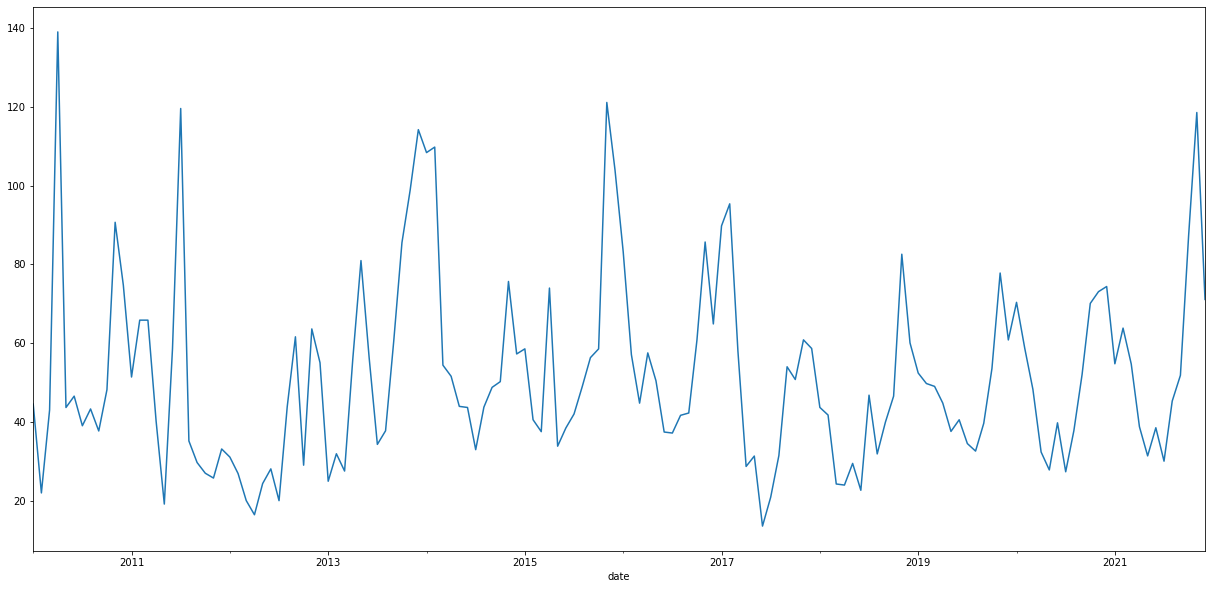

In [ ]:
df = df['NO2'].resample('M').mean()
df.plot(figsize=(21, 10))
plt.show()

**HOLD-OUT**

In [ ]:
train = df[:'2019-12-31']
test = df['2020-01-01':]
print(f"train Veri Setinin Boyutu: {len(train)} (% {(100*len(train)/(len(train)+len(test)))})")
print(f"test Veri Setinin Boyutu: {len(test)} (% {(100*len(test)/(len(train)+len(test)))})")

train Veri Setinin Boyutu: 120 (% 83.33333333333333)
test Veri Setinin Boyutu: 24 (% 16.666666666666668)


**SINGLE EXPONENTIAL SMOOTHING**\
HİPERPARAMETRE OPTİMİZASYONU

In [ ]:
def ses_optimizer(train, alphas, step=24):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.5, 1, 0.01)
best_alpha, best_mae = ses_optimizer(train, alphas)

alpha: 0.5 mae: 18.6784
alpha: 0.51 mae: 18.7406
alpha: 0.52 mae: 18.7998
alpha: 0.53 mae: 18.8559
alpha: 0.54 mae: 18.9092
alpha: 0.55 mae: 18.9594
alpha: 0.56 mae: 19.0067
alpha: 0.57 mae: 19.051
alpha: 0.58 mae: 19.0923
alpha: 0.59 mae: 19.1307
alpha: 0.6 mae: 19.1662
alpha: 0.61 mae: 19.1988
alpha: 0.62 mae: 19.2285
alpha: 0.63 mae: 19.2553
alpha: 0.64 mae: 19.2794
alpha: 0.65 mae: 19.3006
alpha: 0.66 mae: 19.319
alpha: 0.67 mae: 19.3347
alpha: 0.68 mae: 19.3477
alpha: 0.69 mae: 19.358
alpha: 0.7 mae: 19.3657
alpha: 0.71 mae: 19.3708
alpha: 0.72 mae: 19.3732
alpha: 0.73 mae: 19.3732
alpha: 0.74 mae: 19.3706
alpha: 0.75 mae: 19.3655
alpha: 0.76 mae: 19.358
alpha: 0.77 mae: 19.3481
alpha: 0.78 mae: 19.3358
alpha: 0.79 mae: 19.3212
alpha: 0.8 mae: 19.3043
alpha: 0.81 mae: 19.2852
alpha: 0.82 mae: 19.2638
alpha: 0.83 mae: 19.2402
alpha: 0.84 mae: 19.2145
alpha: 0.85 mae: 19.1866
alpha: 0.86 mae: 19.1567
alpha: 0.87 mae: 19.1247
alpha: 0.88 mae: 19.0907
alpha: 0.89 mae: 19.0547
alpha: 0

**MODELİN KURULMASI**

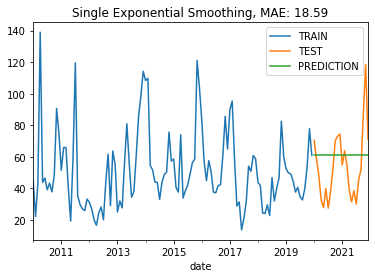

In [ ]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(24)


def plot_no2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train.plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()


plot_no2(train, test, y_pred, "Single Exponential Smoothing")

**DOUBLE EXPONENTIAL SMOOTHING**\
HİPERPARAMETRE OPTİMİZASYONU

In [ ]:
def des_optimizer(train, alphas, betas, step=24):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)
best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)

alpha: 0.01 beta: 0.01 mae: 16.6967
alpha: 0.01 beta: 0.11 mae: 16.9332
alpha: 0.01 beta: 0.21 mae: 19.0109
alpha: 0.01 beta: 0.31 mae: 24.9792
alpha: 0.01 beta: 0.41 mae: 32.1262
alpha: 0.01 beta: 0.51 mae: 38.6435
alpha: 0.01 beta: 0.61 mae: 40.5814
alpha: 0.01 beta: 0.71 mae: 35.5104
alpha: 0.01 beta: 0.81 mae: 24.2255
alpha: 0.01 beta: 0.91 mae: 18.1858
alpha: 0.11 beta: 0.01 mae: 16.951
alpha: 0.11 beta: 0.11 mae: 17.0087
alpha: 0.11 beta: 0.21 mae: 22.21
alpha: 0.11 beta: 0.31 mae: 21.9333
alpha: 0.11 beta: 0.41 mae: 16.8234
alpha: 0.11 beta: 0.51 mae: 16.4975
alpha: 0.11 beta: 0.61 mae: 16.459
alpha: 0.11 beta: 0.71 mae: 17.1133
alpha: 0.11 beta: 0.81 mae: 16.9417
alpha: 0.11 beta: 0.91 mae: 19.2294
alpha: 0.21 beta: 0.01 mae: 16.6634
alpha: 0.21 beta: 0.11 mae: 19.6277
alpha: 0.21 beta: 0.21 mae: 21.6445
alpha: 0.21 beta: 0.31 mae: 22.5838
alpha: 0.21 beta: 0.41 mae: 29.8827
alpha: 0.21 beta: 0.51 mae: 48.5896
alpha: 0.21 beta: 0.61 mae: 74.958
alpha: 0.21 beta: 0.71 mae: 104.6

**MODELİN KURULMASI**

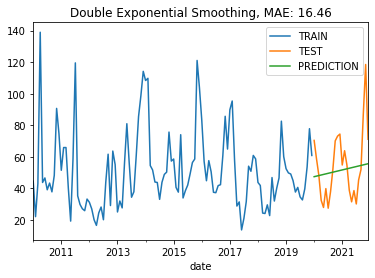

In [ ]:
final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
y_pred = final_des_model.forecast(24)
plot_no2(train, test, y_pred, "Double Exponential Smoothing")

**TRIPLE EXPONENTIAL SMOOTHING**\
HİPERPARAMETRE OPTİMİZASYONU

In [ ]:
def tes_optimizer(train, abg, step=24):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae


alphas = betas = gammas = np.arange(0.20, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))
best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.2, 0.2, 0.2, 11.8]
[0.2, 0.2, 0.3, 12.41]
[0.2, 0.2, 0.4, 12.16]
[0.2, 0.2, 0.5, 11.69]
[0.2, 0.2, 0.6, 11.09]
[0.2, 0.2, 0.7, 10.61]
[0.2, 0.2, 0.8, 9.95]
[0.2, 0.2, 0.9, 9.73]
[0.2, 0.3, 0.2, 21.38]
[0.2, 0.3, 0.3, 20.44]
[0.2, 0.3, 0.4, 17.91]
[0.2, 0.3, 0.5, 14.39]
[0.2, 0.3, 0.6, 12.23]
[0.2, 0.3, 0.7, 12.12]
[0.2, 0.3, 0.8, 11.85]
[0.2, 0.3, 0.9, 12.48]
[0.2, 0.4, 0.2, 25.16]
[0.2, 0.4, 0.3, 22.36]
[0.2, 0.4, 0.4, 16.17]
[0.2, 0.4, 0.5, 11.07]
[0.2, 0.4, 0.6, 12.94]
[0.2, 0.4, 0.7, 26.8]
[0.2, 0.4, 0.8, 36.95]
[0.2, 0.4, 0.9, 32.62]
[0.2, 0.5, 0.2, 24.26]
[0.2, 0.5, 0.3, 19.33]
[0.2, 0.5, 0.4, 10.27]
[0.2, 0.5, 0.5, 8.94]
[0.2, 0.5, 0.6, 26.91]
[0.2, 0.5, 0.7, 46.98]
[0.2, 0.5, 0.8, 50.47]
[0.2, 0.5, 0.9, 47.95]
[0.2, 0.6, 0.2, 23.88]
[0.2, 0.6, 0.3, 17.23]
[0.2, 0.6, 0.4, 16.82]
[0.2, 0.6, 0.5, 63.42]
[0.2, 0.6, 0.6, 16.24]
[0.2, 0.6, 0.7, 49.33]
[0.2, 0.6, 0.8, 52.69]
[0.2, 0.6, 0.9, 52.38]
[0.2, 0.7, 0.2, 29.93]
[0.2, 0.7, 0.3, 22.25]
[0.2, 0.7, 0.4, 55.82]
[0.2, 0.7, 0.5, 

**MODELİN KURULMASI**

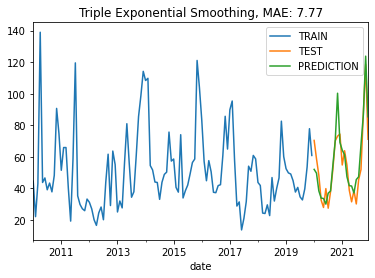

In [ ]:
final_tes_model = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
y_pred = final_tes_model.forecast(24)
plot_no2(train, test, y_pred, "Triple Exponential Smoothing")

**ARIMA**\
HİPERPARAMETRE OPTİMİZASYONU

In [ ]:
def arima_optimizer_aic(train, orders):
    best_aic, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order).fit(disp=0)
            aic = arima_model_result.aic
            if aic < best_aic:
                best_aic, best_params = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    print('Best ARIMA%s AIC=%.2f' % (best_params, best_aic))
    return best_params


p = d = q = range(0, 5)
pdq = list(itertools.product(p, d, q))
best_params_aic = arima_optimizer_aic(train, pdq)

ARIMA(0, 0, 0) AIC=1109.17
ARIMA(0, 0, 1) AIC=1077.98
ARIMA(0, 0, 2) AIC=1077.03
ARIMA(0, 0, 3) AIC=1077.04
ARIMA(0, 0, 4) AIC=1078.79
ARIMA(0, 1, 0) AIC=1096.94
ARIMA(0, 1, 1) AIC=1090.30
ARIMA(0, 1, 2) AIC=1075.99
ARIMA(0, 1, 3) AIC=1074.81
ARIMA(0, 1, 4) AIC=1074.64
ARIMA(0, 2, 0) AIC=1191.12
ARIMA(0, 2, 1) AIC=1095.53
ARIMA(1, 0, 0) AIC=1074.31
ARIMA(1, 0, 1) AIC=1075.76
ARIMA(1, 0, 2) AIC=1077.66
ARIMA(1, 0, 3) AIC=1078.81
ARIMA(1, 0, 4) AIC=1080.69
ARIMA(1, 1, 0) AIC=1094.25
ARIMA(1, 2, 0) AIC=1159.26
ARIMA(1, 2, 1) AIC=1093.23
ARIMA(2, 0, 0) AIC=1075.82
ARIMA(2, 0, 1) AIC=1076.72
ARIMA(2, 0, 2) AIC=1078.72
ARIMA(2, 0, 3) AIC=1079.48
ARIMA(2, 0, 4) AIC=1081.45
ARIMA(2, 1, 0) AIC=1089.54
ARIMA(2, 1, 1) AIC=1073.37
ARIMA(2, 1, 2) AIC=1074.22
ARIMA(2, 2, 0) AIC=1132.97
ARIMA(2, 2, 1) AIC=1088.99
ARIMA(2, 2, 3) AIC=1095.86
ARIMA(2, 2, 4) AIC=1092.81
ARIMA(3, 0, 0) AIC=1077.75
ARIMA(3, 0, 1) AIC=1077.39
ARIMA(3, 0, 2) AIC=1075.97
ARIMA(3, 0, 3) AIC=1077.03
ARIMA(3, 0, 4) AIC=1077.38
A

**MODELİN KURULMASI**

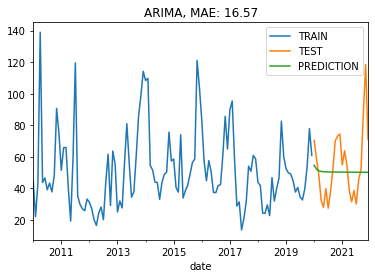

In [ ]:
arima_model = ARIMA(train, best_params_aic).fit(disp=0)
y_pred = arima_model.forecast(24)[0]
y_pred = pd.Series(y_pred, index=test.index)
plot_no2(train, test, y_pred, "ARIMA")

**SARIMA**\
HİPERPARAMETRE OPTİMİZASYONU

In [ ]:
def sarima_optimizer_aic(train, pdq, seasonal_pdq):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model = SARIMAX(train, order=param, seasonal_order=param_seasonal)
                results = sarimax_model.fit(disp=0)
                aic = results.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, aic))
            except:
                continue
    print('SARIMA{}x{}12 - AIC:{}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order


p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
best_order, best_seasonal_order = sarima_optimizer_aic(train, pdq, seasonal_pdq)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1311.1377127322567
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1241.6842733347444
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1233.5593571942898
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1056.2738473048928
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1007.7630286121871
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1009.7078439711403
SARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:1041.8316972535736
SARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:977.6917326440475
SARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:955.2613636365636
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1180.413449001092
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1139.029789018547
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1140.9098728136016
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1032.7975356444297
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1009.7160241935954
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:1006.4473279037845
SARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:1006.5911935563396
SARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:964.7321202123878
SARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AI

**MODELİN KURULMASI**

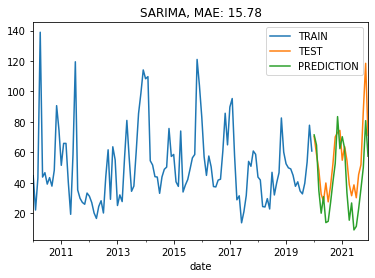

In [ ]:
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
sarima_final_model = model.fit(disp=0)
y_pred_test = sarima_final_model.get_forecast(steps=24)
y_pred = y_pred_test.predicted_mean
y_pred = pd.Series(y_pred, index=test.index)
plot_no2(train, test, y_pred, "SARIMA")

**SONUÇLARIN KARŞILAŞTIRILMASI**\
Her bir yöntemin başarı ortalaması aşağıda verilmiştir. Görülebileceği üzere en iyi sonucu veren Triple Exponential Smoothing yöntemi olmuştur.\
SES MAE: 18.58\
DES MAE: 16.46\
TES MAE: 7.77\
ARIMA: 16.57\
SARIMA: 15.78

**FİNAL MODELİNİNİ KURULMASI**

In [ ]:
final_tes_model = ExponentialSmoothing(df, trend="mul", seasonal="mul", seasonal_periods=12).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

**2022 YILI OCAK AYI İÇİN TAHMİN**

In [ ]:
y_pred = final_tes_model.forecast(1)
print(y_pred)

2022-01-31    72.120338
Freq: M, dtype: float64


**SONUÇ ve DEĞERLENDİRME**\
Single Exponential Smoothing, Double Exponential Smoothing, Triple Exponential Smoothing, ARIMA ve SARIMA yöntemleriyle değerlendirme yapılmış ve sonuçları karşılaştırılmıştır. En iyi başarıya sahip yöntem kullanılarak oluşturulan final modellemesiyle 2022 yılı Ocak ayı için Ankara-Bahçelievler İstasyonu' nun azot dioksit (NO2) emisyonu 72.12 olarak tahmin edilmiş olup www.havaizleme.gov.tr adresinden alınan gerçek sonuç ise 68.08' dir. Tahmin başarısının oldukça iyi olduğu düşünülmekte olup hiperparametre optimizasyonu veya diğer makine öğrenmesi yöntemleriyle tahmin başarısı artırılabilir.